In [1]:
import os
import random
import re
import sys
from datetime import datetime
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn import preprocessing
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [2]:
path = "/Users/M283455/VAE_prject/scripts/"
sys.path.insert(0, path)

In [3]:
import VAE_tybalt
from VAE_tybalt import VAE

In [4]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [5]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

In [6]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
rnaseq_df = pd.read_table(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [7]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

In [8]:
# How well does the model reconstruct the input RNAseq data
def VAE_latent_out(df):
    mu = model.forward(torch.tensor(df.values, dtype=torch.float32))[2]
    sigma = model.forward(torch.tensor(df.values, dtype=torch.float32))[3]

    column_names = [str(i) for i in range(100)]

    mu = pd.DataFrame(mu.detach().numpy(), columns=column_names)
    sigma = pd.DataFrame(sigma.detach().numpy(), columns=column_names)

    return mu, sigma

In [9]:
latent_mu, latent_sigma = VAE_latent_out(rnaseq_df)

In [10]:
import pandas as pd
import umap.umap_ as umap

# Assuming you have a pandas DataFrame named 'latent_mu' with the data

# Extract the features from the DataFrame
features = latent_mu.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result = umap.UMAP().fit_transform(features)

# Create a new DataFrame with UMAP coordinates
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df = pd.concat([latent_mu, umap_df], axis=1)

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/umap/distances.py:108

In [11]:
result_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,UMAP1,UMAP2
0,-0.412649,0.710175,-0.795810,0.887554,-1.259630,-0.847377,-0.060489,-0.390947,-0.617078,-0.224537,...,-0.796305,-0.167217,-0.399551,-0.202910,0.457631,-0.641116,0.087899,-0.780150,10.881627,-7.183458
1,-0.245373,0.819964,-0.109069,0.217647,-0.714195,-0.172589,-0.555804,-0.944640,-0.459089,-0.684127,...,-1.197324,0.372887,-0.260377,0.153839,0.438741,-1.061390,-0.179697,-0.900864,10.580486,-7.365645
2,-0.603684,0.487100,-0.804239,0.921643,-0.882696,-0.606947,0.374666,-0.536518,-0.405642,-0.688019,...,-1.005515,-0.384390,-0.408506,-0.529698,-0.121677,-0.461944,-0.349346,-0.464267,11.337085,-6.556289


In [12]:
embedded_dataframe = result_df.copy()

In [76]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
df = pd.read_table(tcga_tybalt_file_location)
# df.drop(columns=df.columns[0], axis=1, inplace=True)

In [14]:
embedded_dataframe["id"] = df["Unnamed: 0"]

In [15]:
embedded_dataframe["id"]
# print(embedded_dataframe['id'].str.len().min())

0        TCGA-02-0047-01
1        TCGA-02-0055-01
2        TCGA-02-2483-01
3        TCGA-02-2485-01
4        TCGA-02-2486-01
              ...       
10454    TCGA-ZS-A9CG-01
10455    TCGA-ZT-A8OM-01
10456    TCGA-ZU-A8S4-01
10457    TCGA-ZU-A8S4-11
10458    TCGA-ZX-AA5X-01
Name: id, Length: 10459, dtype: object

In [16]:
# clinical data
clincal_file = "../../VAE_prject_data/raw/clinical_data.tsv"
clincal_df = pd.read_table(clincal_file)

In [17]:
clincal_df["id"] = clincal_df.portion_id.str[: embedded_dataframe["id"].str.len().min()]

In [18]:
clincal_df.shape

(11284, 18)

In [19]:
embedded_dataframe.shape

(10459, 103)

In [20]:
merged_latent_clinical_df = pd.merge(
    clincal_df, embedded_dataframe, on="id", how="inner"
)

In [21]:
merged_latent_clinical_df.head(3)

,sample_id,ethnicity,year_of_diagnosis,gender,race,organ,percent_tumor_nuclei,age_at_diagnosis,sample_type,analysis_center,...,92,93,94,95,96,97,98,99,UMAP1,UMAP2
0,TCGA-CD-8534,not hispanic or latino,2011,male,asian,Stomach,85.0,41.0,Primary Tumor,BCGSC,...,-1.217980,0.612282,-0.695295,-0.843861,-0.171759,0.241048,-0.611222,-0.373460,3.095103,1.780947
1,TCGA-ER-A19A,not hispanic or latino,2006,male,white,Skin,85.0,79.0,Metastatic,UNC,...,-0.383564,0.383218,0.691871,0.204385,0.653908,0.095414,0.080750,-0.675321,17.489510,5.778217
2,TCGA-C5-A1M8,not hispanic or latino,2001,female,white,Cervix,85.0,43.0,Primary Tumor,UNC,...,1.256918,-2.735865,0.569573,-0.409968,-0.565986,0.200135,-1.258146,0.696444,9.923718,7.442452


In [22]:
clincal_df.columns

Index(['sample_id', 'ethnicity', 'year_of_diagnosis', 'gender', 'race',
       'organ', 'percent_tumor_nuclei', 'age_at_diagnosis', 'sample_type',
       'analysis_center', 'vital_status', 'acronym', 'portion_id', 'disease',
       'drug', 'platform', 'stage', 'id'],
      dtype='object')

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

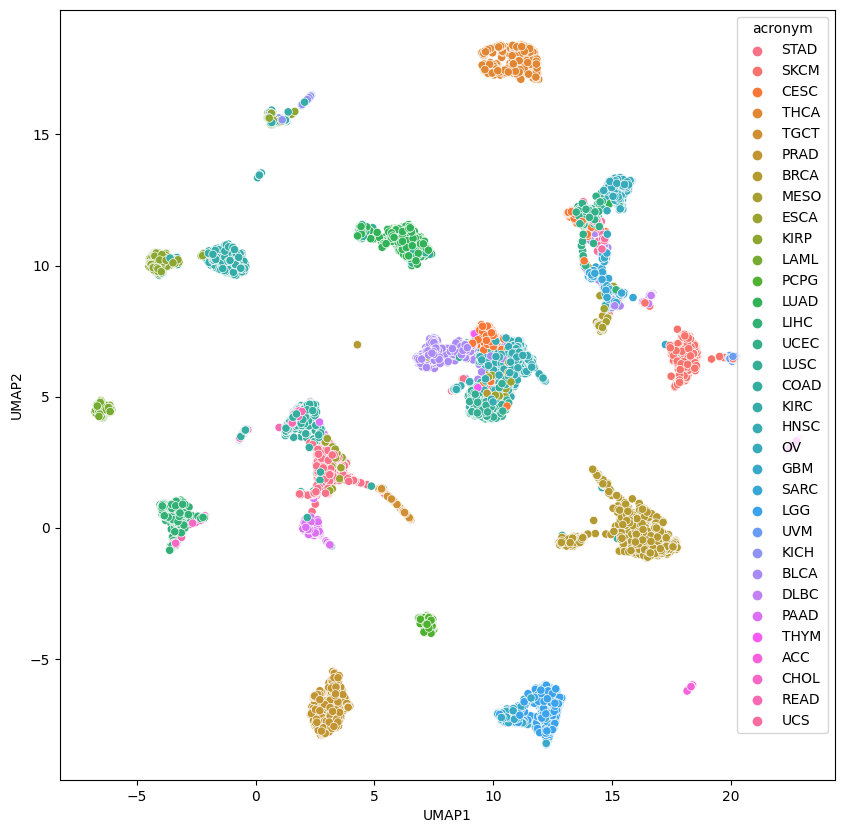

In [23]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="acronym")

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

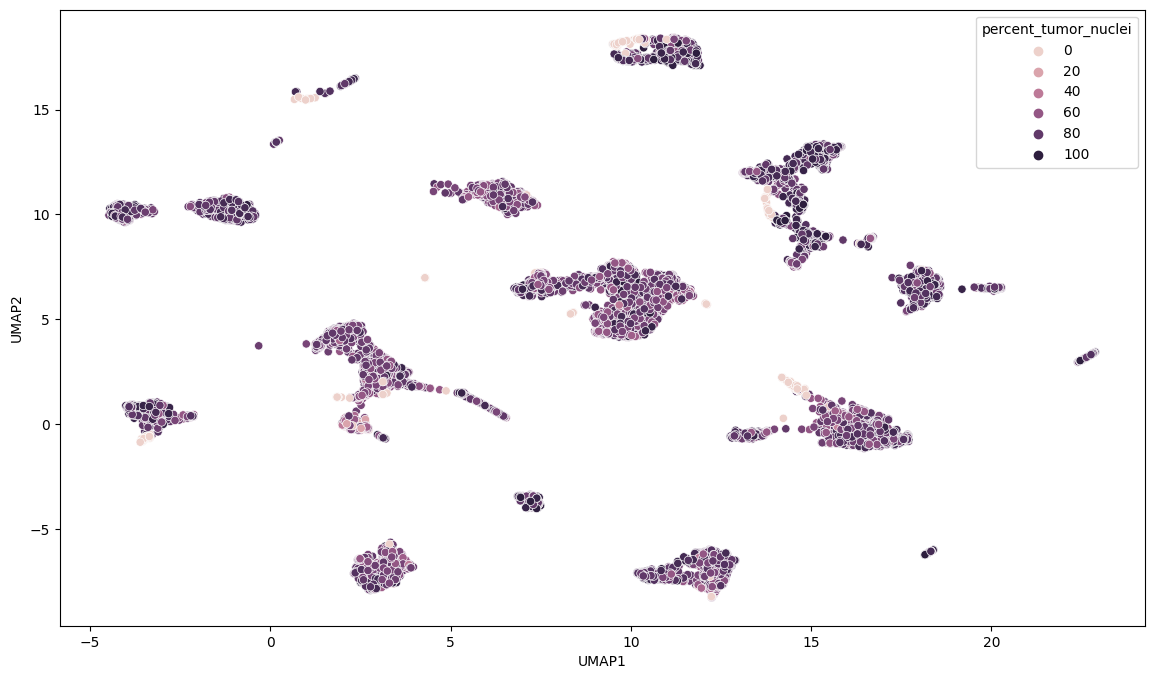

In [24]:
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="percent_tumor_nuclei"
)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

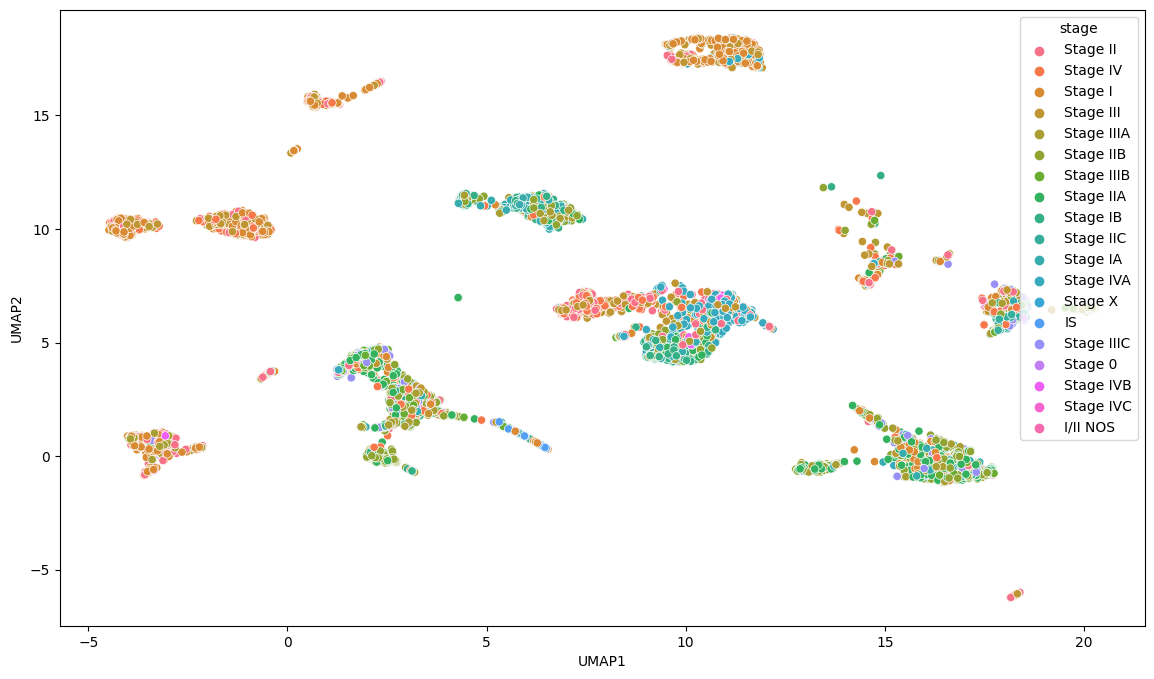

In [25]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="stage")

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

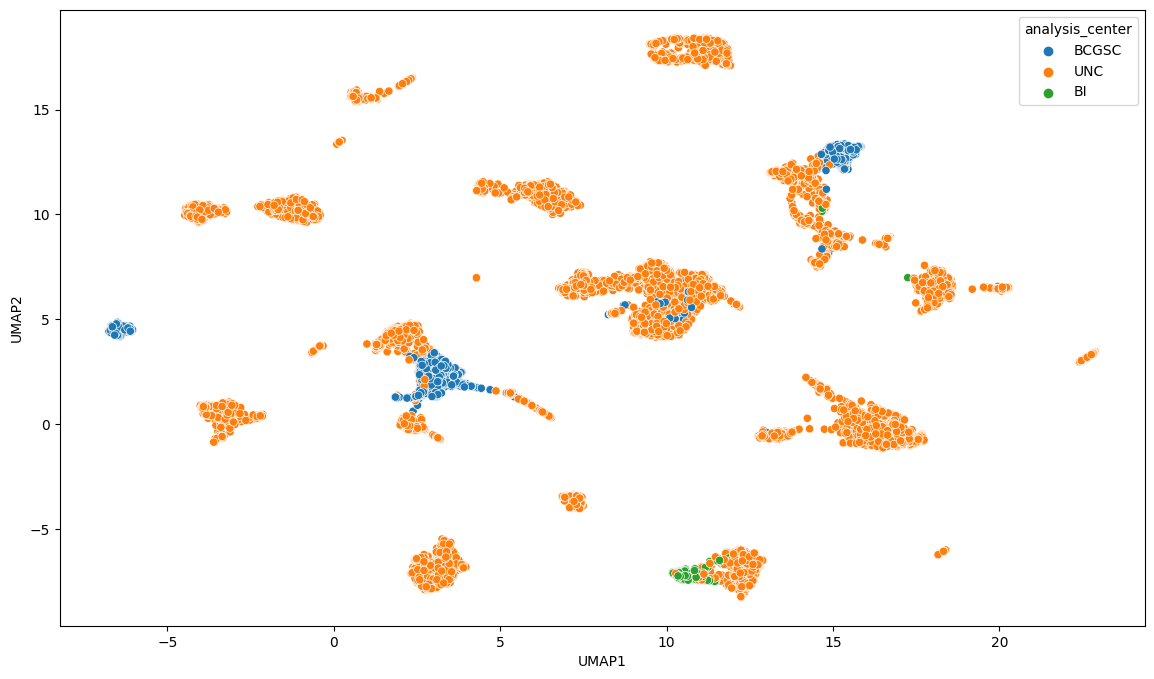

In [26]:
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="analysis_center"
)

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

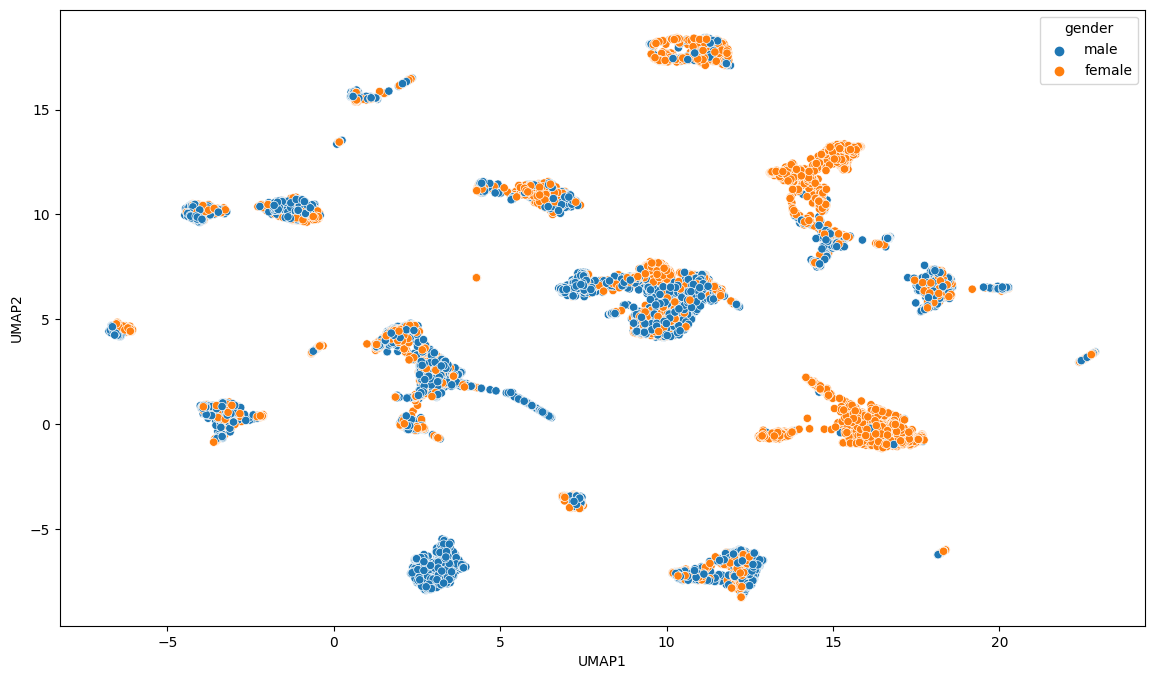

In [27]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="gender")

In [28]:
# perform a multiclass classification

In [29]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split

# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["acronym"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.6598129029989769
F1-score: 0.7751584778681503
Accuracy: 0.9083969465648855
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.99      0.95      0.97       160
           2       0.72      0.95      0.82        19
           3       0.63      0.83      0.72        23
           4       0.00      0.00      0.00         1
           5       0.94      0.94      0.94        16
           6       0.80      1.00      0.89         4
           7       1.00      0.88      0.93         8
           8       0.82      0.97      0.89        29
           9       0.90      0.82      0.86        22
          10       0.95      0.91      0.93        22
          11       0.00      0.00      0.00         4
          12       0.95      0.86      0.90        22
          13       0.94      0.91      0.92        33
          14       1.00      1.00      1.00         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [30]:
# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

merged_l_df["organ"] = merged_l_df["organ"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["organ"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.4451180442503578
F1-score: 0.8048978679118057
Accuracy: 0.8498727735368957
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.99      0.95      0.97       160
           2       0.92      1.00      0.96        23
           3       0.41      0.70      0.52        23
           4       1.00      0.95      0.98        22
           5       1.00      0.88      0.93         8
           6       0.51      0.65      0.57        51
           7       1.00      0.95      0.98        22
           8       1.00      1.00      1.00        22
           9       0.97      0.94      0.95        32
          10       1.00      1.00      1.00         9

    accuracy                           0.85       393
   macro avg       0.80      0.82      0.80       393
weighted avg       0.84      0.85      0.84       393



/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [31]:
# define functoins to add noise
# Define function to add gussian noise with different variance to each element of a pandas dataframe
def add_gaussian_noise(df, variances):
    assert len(variances) == len(
        df.columns
    ), "Number of variances must match the number of columns in the DataFrame."

    # Create a DataFrame with the same shape as the input DataFrame, filled with Gaussian random noise
    noise = pd.DataFrame(
        np.random.normal(0, np.sqrt(variances), size=df.shape), columns=df.columns
    )

    # Add the noise to the input DataFrame
    noisy_df = df + noise

    # Scale RNAseq data using zero-one normalization
    scaled_zeroone_df = preprocessing.MinMaxScaler().fit_transform(noisy_df)
    scaled_zeroone_df = pd.DataFrame(
        scaled_zeroone_df, columns=df.columns, index=df.index
    )

    return scaled_zeroone_df


# generate variances vector with a given upper values of maximum variance
def variance_vec(max_var, df):
    variances = np.linspace(0, max_var, len(df.columns))
    np.random.shuffle(variances)
    return variances

In [32]:
dataset_names_max_var = {
    "tcga_rnaseq_df_0p" + str(int(i * 100)): round(i, 2)
    for i in np.linspace(0.01, 0.9, 6)
}

In [33]:
# create a dictionary containing datasets with variable noises
noisy_datasets = {}
for i in dataset_names_max_var.keys():
    variance = variance_vec(dataset_names_max_var[i], rnaseq_df)
    noisy_datasets[i] = add_gaussian_noise(rnaseq_df, variance)

In [34]:
noisy_datasets.keys()

dict_keys(['tcga_rnaseq_df_0p1', 'tcga_rnaseq_df_0p18', 'tcga_rnaseq_df_0p36', 'tcga_rnaseq_df_0p54', 'tcga_rnaseq_df_0p72', 'tcga_rnaseq_df_0p90'])

Analysis with noisy data

In [35]:
latent_mu_0p90, latent_sigma_0p90 = VAE_latent_out(
    noisy_datasets["tcga_rnaseq_df_0p90"]
)

In [36]:
# Extract the features from the DataFrame
features_0p90 = latent_mu_0p90.iloc[:, 0:-1].values

# Perform UMAP dimensionality reduction
umap_result_0p90 = umap.UMAP().fit_transform(features_0p90)

# Create a new DataFrame with UMAP coordinates
umap_df_0p90 = pd.DataFrame(umap_result_0p90, columns=["UMAP1", "UMAP2"])

# Concatenate the UMAP DataFrame with the original DataFrame
result_df_0p90 = pd.concat([latent_mu_0p90, umap_df_0p90], axis=1)

In [37]:
embedded_dataframe_0p90 = result_df_0p90.copy()

In [38]:
embedded_dataframe_0p90["id"] = df["Unnamed: 0"]

In [39]:
merged_latent_clinical_df_0p90 = pd.merge(
    clincal_df, embedded_dataframe_0p90, on="id", how="inner"
)

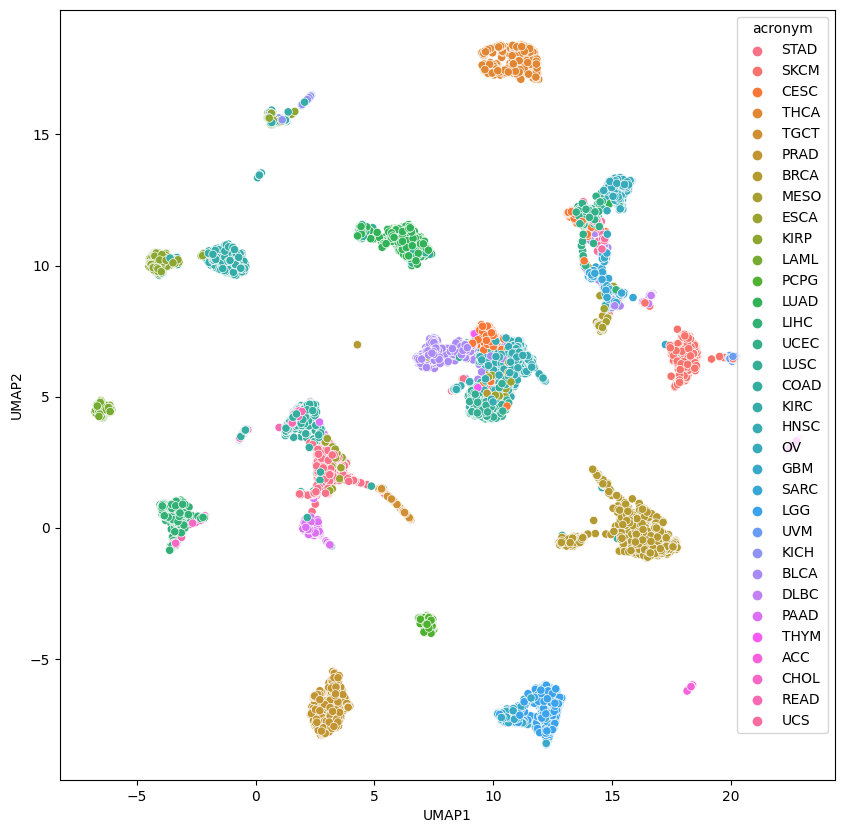

In [40]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=merged_latent_clinical_df, x="UMAP1", y="UMAP2", hue="acronym")
plt.savefig("../../Desktop/embedded.png")

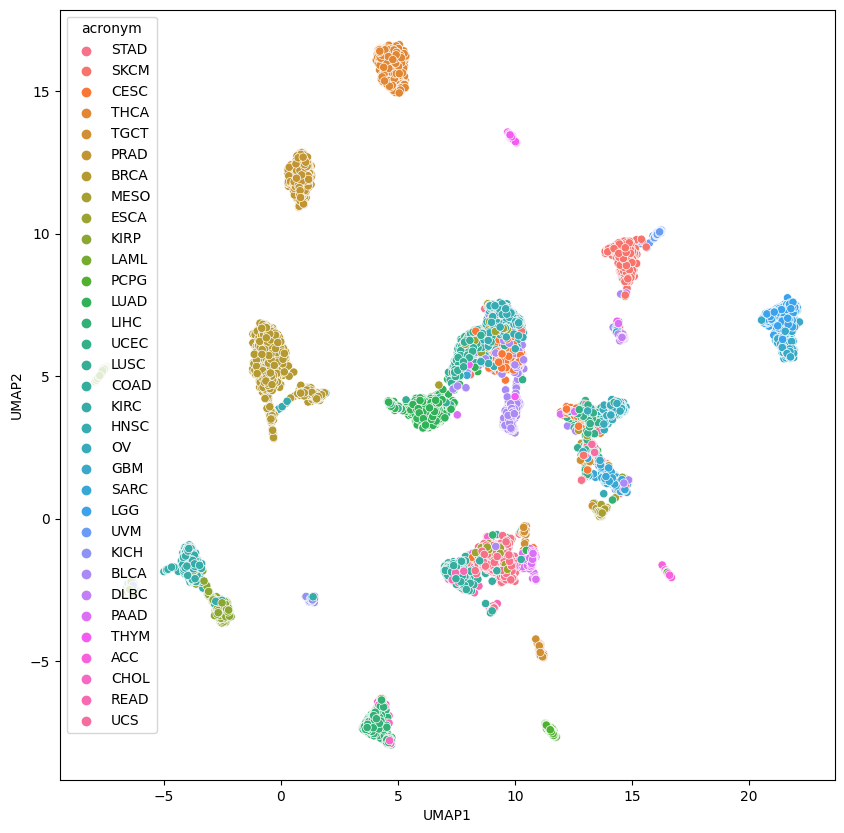

In [41]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=merged_latent_clinical_df_0p90, x="UMAP1", y="UMAP2", hue="acronym"
)
plt.savefig("../../Desktop/embedded_0p9.png")

In [42]:
specific_values = ["BRCA"]

In [43]:
specific_values

['BRCA']

In [44]:
merged_latent_clinical_filtered_df = merged_latent_clinical_df[
    merged_latent_clinical_df["acronym"].isin(specific_values)
]
merged_latent_clinical_filtered_df_0p90 = merged_latent_clinical_df_0p90[
    merged_latent_clinical_df_0p90["acronym"].isin(specific_values)
]

<Axes: title={'center': 'BRCA'}, xlabel='UMAP1', ylabel='UMAP2'>

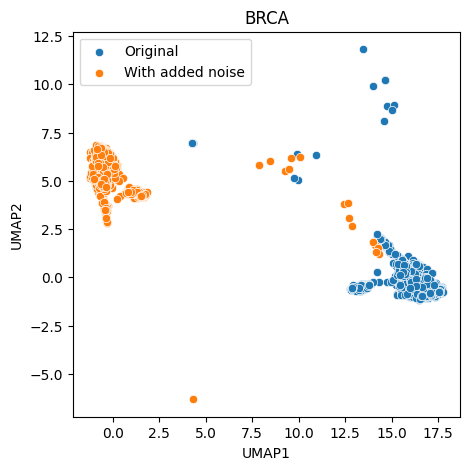

In [45]:
plt.figure(figsize=(5, 5))
plt.title(specific_values[0])
sns.scatterplot(
    data=merged_latent_clinical_filtered_df, x="UMAP1", y="UMAP2", label="Original"
)
sns.scatterplot(
    data=merged_latent_clinical_filtered_df_0p90,
    x="UMAP1",
    y="UMAP2",
    label="With added noise",
)

In [46]:
# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df.copy()
merged_l_df = merged_l_df.dropna()

merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["acronym"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.6598129029989769
F1-score: 0.7751584778681503
Accuracy: 0.9083969465648855
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86        21
           1       0.99      0.95      0.97       160
           2       0.72      0.95      0.82        19
           3       0.63      0.83      0.72        23
           4       0.00      0.00      0.00         1
           5       0.94      0.94      0.94        16
           6       0.80      1.00      0.89         4
           7       1.00      0.88      0.93         8
           8       0.82      0.97      0.89        29
           9       0.90      0.82      0.86        22
          10       0.95      0.91      0.93        22
          11       0.00      0.00      0.00         4
          12       0.95      0.86      0.90        22
          13       0.94      0.91      0.92        33
          14       1.00      1.00      1.00         9

    accuracy            

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [47]:
# Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

# Split the DataFrame into features (X) and labels (y)
merged_l_df = merged_latent_clinical_df_0p90.copy()
merged_l_df = merged_l_df.dropna()

merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

X = merged_l_df[["UMAP1", "UMAP2"]]
y = merged_l_df["acronym"]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Compute roc_auc_score
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro")

# Compute F1-score
f1 = f1_score(y_test, y_pred, average="macro")

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)

# Compute classification report
classification_metrics = classification_report(y_test, y_pred)

# Print the AUC-ROC, F1-score, accuracy, and classification report
print("AUC-ROC:", auc_roc)
print("F1-score:", f1)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_metrics)

AUC-ROC: 0.8541211651709208
F1-score: 0.8425653874476021
Accuracy: 0.905852417302799
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.76      0.70        21
           1       0.99      0.97      0.98       160
           2       0.78      0.95      0.86        19
           3       0.77      0.87      0.82        23
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00        16
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         8
           8       0.96      0.93      0.95        29
           9       0.82      0.82      0.82        22
          10       0.76      0.86      0.81        22
          11       0.00      0.00      0.00         4
          12       0.90      0.82      0.86        22
          13       0.90      0.82      0.86        33
          14       1.00      1.00      1.00         9

    accuracy             

/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/M283455/VAE_prject/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F

In [48]:
%pwd

'/Users/M283455/VAE_prject/notebooks'

In [49]:
np.random.seed(123)

In [50]:
ov_df = pd.read_table("../../VAE_prject_data/raw/ov_subtype_info.tsv", index_col=0)
ov_df.head(2)

,DATASET,SUBTYPE,AGE,PLATINUM-STATUS,STAGE,GRADE,TUMORRESIDUALDISEASE,SURVIVALSTATUS,SURVIVALMONTHS,RECURRENCE-STATUS,...,Proliferative ssGSEA raw score,Differentiated ssGSEA normalized score,Immunoreactive ssGSEA normalized score,Mesenchymal ssGSEA normalized score,Proliferative ssGSEA normalized score,Differentiated-binary,Immunoreactive-binary,Mesenchymal-binary,Proliferative-binary,SILHOUETTE WIDTH
ID,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1357-01,TCGA-discovery,Immunoreactive,52.0,unknown,IIIB,G3,unknown,LIVING,unknown,unknown,...,127.0,0.765,0.948,0.406,0.169,1,1,0,0,0.184202
TCGA-04-1519-01,TCGA-discovery,Proliferative,48.0,unknown,IIIC,G3,unknown,unknown,unknown,unknown,...,"2,578.4",0.555,0.128,0.331,0.750,1,0,0,1,0.088401


In [51]:
embedded_dataframe["id"]

0        TCGA-02-0047-01
1        TCGA-02-0055-01
2        TCGA-02-2483-01
3        TCGA-02-2485-01
4        TCGA-02-2486-01
              ...       
10454    TCGA-ZS-A9CG-01
10455    TCGA-ZT-A8OM-01
10456    TCGA-ZU-A8S4-01
10457    TCGA-ZU-A8S4-11
10458    TCGA-ZX-AA5X-01
Name: id, Length: 10459, dtype: object

In [52]:
ov_df["id"] = list(ov_df.index)

In [53]:
ov_df["id"]

ID
TCGA-04-1357-01    TCGA-04-1357-01
TCGA-04-1519-01    TCGA-04-1519-01
TCGA-04-1341-01    TCGA-04-1341-01
TCGA-59-2348-01    TCGA-59-2348-01
TCGA-13-0885-01    TCGA-13-0885-01
                        ...       
TCGA-61-2009-01    TCGA-61-2009-01
TCGA-13-0724-01    TCGA-13-0724-01
TCGA-24-1928-01    TCGA-24-1928-01
TCGA-31-1953-01    TCGA-31-1953-01
TCGA-13-0755-01    TCGA-13-0755-01
Name: id, Length: 489, dtype: object

In [54]:
# Find the rows of dataframe where the column values match
embedded_dataframe

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,UMAP1,UMAP2,id
0,-0.412649,0.710175,-0.795810,0.887554,-1.259630,-0.847377,-0.060489,-0.390947,-0.617078,-0.224537,...,-0.167217,-0.399551,-0.202910,0.457631,-0.641116,0.087899,-0.780150,10.881627,-7.183458,TCGA-02-0047-01
1,-0.245373,0.819964,-0.109069,0.217647,-0.714195,-0.172589,-0.555804,-0.944640,-0.459089,-0.684127,...,0.372887,-0.260377,0.153839,0.438741,-1.061390,-0.179697,-0.900864,10.580486,-7.365645,TCGA-02-0055-01
2,-0.603684,0.487100,-0.804239,0.921643,-0.882696,-0.606947,0.374666,-0.536518,-0.405642,-0.688019,...,-0.384390,-0.408506,-0.529698,-0.121677,-0.461944,-0.349346,-0.464267,11.337085,-6.556289,TCGA-02-2483-01
3,-0.705112,0.428702,-0.811855,1.031394,-0.850781,-0.971681,0.240144,-0.694556,-0.723566,-0.541971,...,-0.456377,-0.615512,-0.625768,0.075453,-0.814567,-0.538621,-0.647175,10.741288,-7.132039,TCGA-02-2485-01
4,-0.932381,0.585547,-0.188842,1.906949,-0.271162,-0.943133,-0.273044,-1.807226,-0.740219,-0.940950,...,-0.384812,-0.615806,-0.265220,0.459351,-0.942588,-0.377428,-1.040893,10.411526,-7.317520,TCGA-02-2486-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10454,0.139139,-0.640274,-0.334034,-0.486224,-0.063950,0.945037,1.194455,-0.870859,-0.871439,0.465738,...,-0.280572,-0.355021,0.485423,-0.656456,-0.794813,-1.404361,-1.157337,-3.855593,0.482803,TCGA-ZS-A9CG-01
10455,-0.315892,-1.366973,0.218876,-0.519741,0.607839,-1.115401,-0.270762,-0.374194,0.056071,-0.826668,...,-0.870565,0.077675,-0.436978,-0.738178,0.174801,-1.251524,1.092897,22.805483,3.352615,TCGA-ZT-A8OM-01
10456,-0.073617,-0.158921,0.017615,0.435798,-0.594136,0.336026,-1.320958,-0.807026,-0.897723,-0.073379,...,-0.243061,-0.486582,0.286068,-0.111519,-0.391158,-0.681479,-0.968405,-2.128548,0.363661,TCGA-ZU-A8S4-01
10457,0.580346,-0.689230,-0.486750,-0.453451,-0.694208,0.587395,0.643679,-0.227316,-0.700483,1.138503,...,0.178604,-0.283126,0.779633,0.295525,-0.551215,-0.901352,-1.070062,-3.461471,-0.637036,TCGA-ZU-A8S4-11


In [55]:
merged_latent_ov_df = pd.merge(ov_df, embedded_dataframe, on="id", how="inner")

In [56]:
merged_latent_ov_df.head(5)

,DATASET,SUBTYPE,AGE,PLATINUM-STATUS,STAGE,GRADE,TUMORRESIDUALDISEASE,SURVIVALSTATUS,SURVIVALMONTHS,RECURRENCE-STATUS,...,92,93,94,95,96,97,98,99,UMAP1,UMAP2
0,TCGA-discovery,Immunoreactive,52.0,unknown,IIIB,G3,unknown,LIVING,unknown,unknown,...,-0.329117,0.110988,-0.458211,-0.027104,0.675914,-0.059074,-0.151948,0.256432,14.949104,13.251275
1,TCGA-discovery,Proliferative,48.0,unknown,IIIC,G3,unknown,unknown,unknown,unknown,...,-0.826315,-0.706632,-0.804162,0.614441,0.042320,-0.176585,-0.399037,0.160696,15.224265,12.511671
2,TCGA-discovery,Differentiated,59.0,unknown,IIIC,G3,unknown,LIVING,60,unknown,...,-0.794870,-0.349548,-0.179296,0.308497,0.281201,0.063110,0.105961,0.230103,15.180092,13.153038
3,TCGA-discovery,Differentiated,67.0,unknown,IIIC,G3,unknown,LIVING,60,unknown,...,-0.746281,-0.277963,-0.390403,0.535119,0.400384,0.032498,-0.172100,-0.006402,15.237428,13.024620
4,TCGA-discovery,Mesenchymal,66.0,SENSITIVE,IIIC,G3,Optimal,LIVING,60,unknown,...,-1.000389,0.212442,-0.412849,0.272519,0.577770,-0.220292,-0.190422,0.171157,15.677359,13.040998


In [57]:
merged_latent_ov_df.columns[:30]

Index(['DATASET', 'SUBTYPE', 'AGE', 'PLATINUM-STATUS', 'STAGE', 'GRADE',
       'TUMORRESIDUALDISEASE', 'SURVIVALSTATUS', 'SURVIVALMONTHS',
       'RECURRENCE-STATUS', 'RECURRENCE-MONTHS', 'CloverLeaf',
       'Differentiated ssGSEA raw score', 'Immunoreactive ssGSEA raw score',
       'Mesenchymal ssGSEA raw score', 'Proliferative ssGSEA raw score',
       'Differentiated ssGSEA normalized score',
       'Immunoreactive ssGSEA normalized score',
       'Mesenchymal ssGSEA normalized score',
       'Proliferative ssGSEA normalized score', 'Differentiated-binary',
       'Immunoreactive-binary', 'Mesenchymal-binary', 'Proliferative-binary',
       'SILHOUETTE WIDTH', 'id', '0', '1', '2', '3'],
      dtype='object')

/var/folders/pz/58p838cs59d_ph9d15d3ltgc0000gs/T/ipykernel_51134/314380683.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = merged_latent_ov_df.groupby("SUBTYPE").mean()


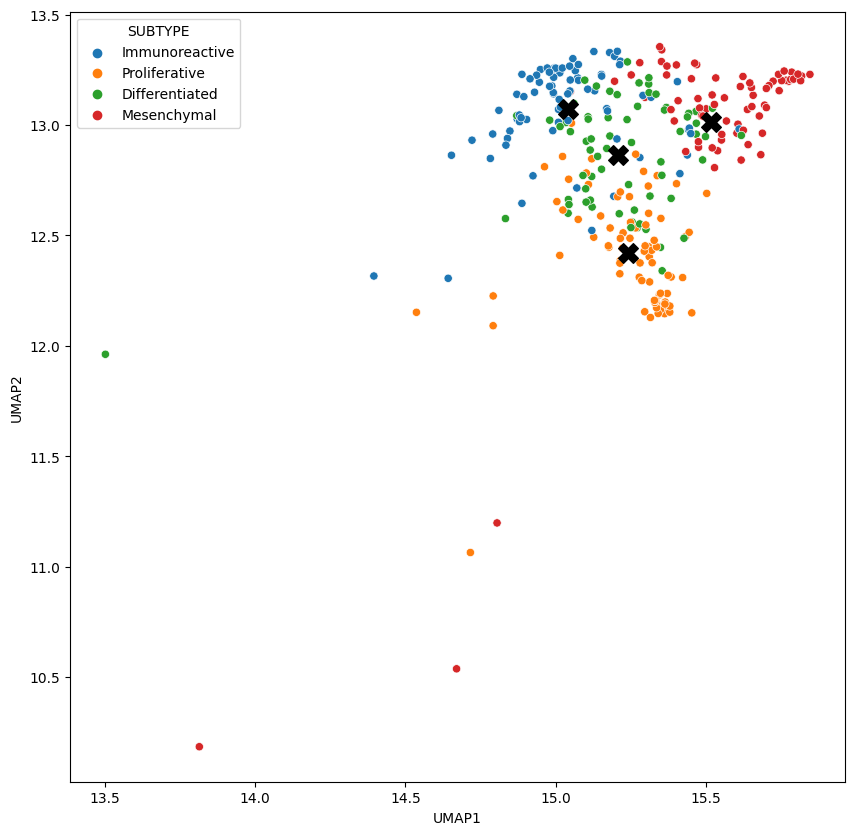

In [58]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=merged_latent_ov_df, x="UMAP1", y="UMAP2", hue="SUBTYPE")
# Calculate the mean for each category
means = merged_latent_ov_df.groupby("SUBTYPE").mean()

# Add mean points to the plot
for index, row in means.iterrows():
    plt.scatter(row["UMAP1"], row["UMAP2"], marker="X", color="black", s=200)

# plt.xlim(6, 8.5)
# plt.ylim(-4, -2)
plt.savefig("../../Desktop/Subtype.png")

In [59]:
merged_latent_ov_df.columns[:40]

Index(['DATASET', 'SUBTYPE', 'AGE', 'PLATINUM-STATUS', 'STAGE', 'GRADE',
       'TUMORRESIDUALDISEASE', 'SURVIVALSTATUS', 'SURVIVALMONTHS',
       'RECURRENCE-STATUS', 'RECURRENCE-MONTHS', 'CloverLeaf',
       'Differentiated ssGSEA raw score', 'Immunoreactive ssGSEA raw score',
       'Mesenchymal ssGSEA raw score', 'Proliferative ssGSEA raw score',
       'Differentiated ssGSEA normalized score',
       'Immunoreactive ssGSEA normalized score',
       'Mesenchymal ssGSEA normalized score',
       'Proliferative ssGSEA normalized score', 'Differentiated-binary',
       'Immunoreactive-binary', 'Mesenchymal-binary', 'Proliferative-binary',
       'SILHOUETTE WIDTH', 'id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13'],
      dtype='object')

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

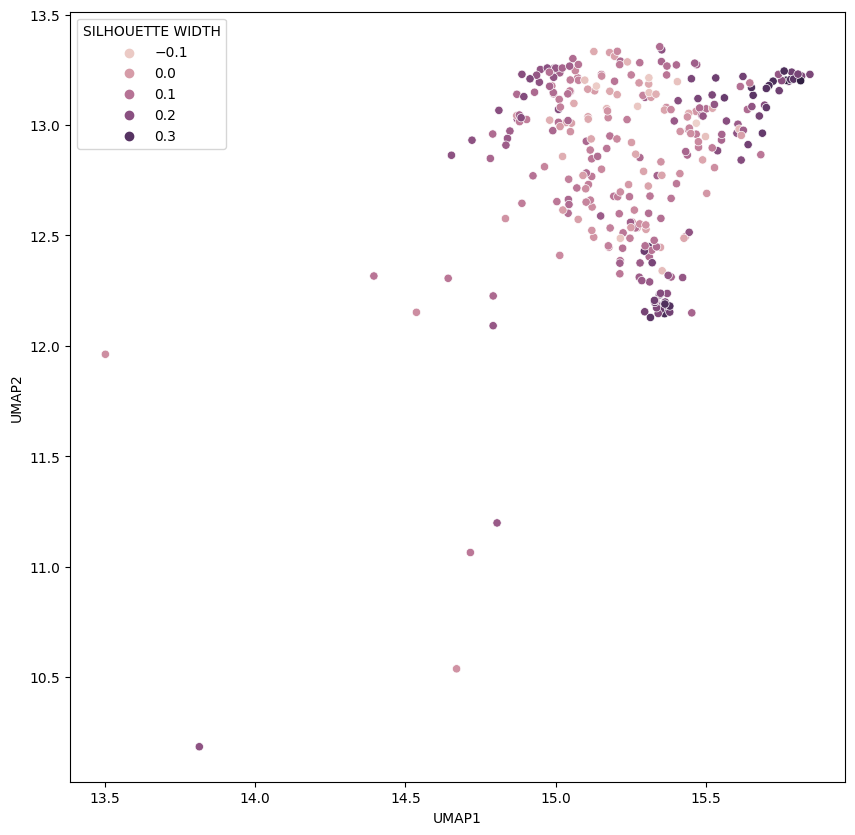

In [60]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=merged_latent_ov_df,
    x="UMAP1",
    y="UMAP2",
    hue="SILHOUETTE WIDTH",
)
# plt.xlim(6, 8.5)
# plt.ylim(-4, -2)

In [61]:
merged_latent_ov_df_0p90 = pd.merge(
    ov_df, embedded_dataframe_0p90, on="id", how="inner"
)

/var/folders/pz/58p838cs59d_ph9d15d3ltgc0000gs/T/ipykernel_51134/254229252.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = merged_latent_ov_df_0p90.groupby("SUBTYPE").mean()


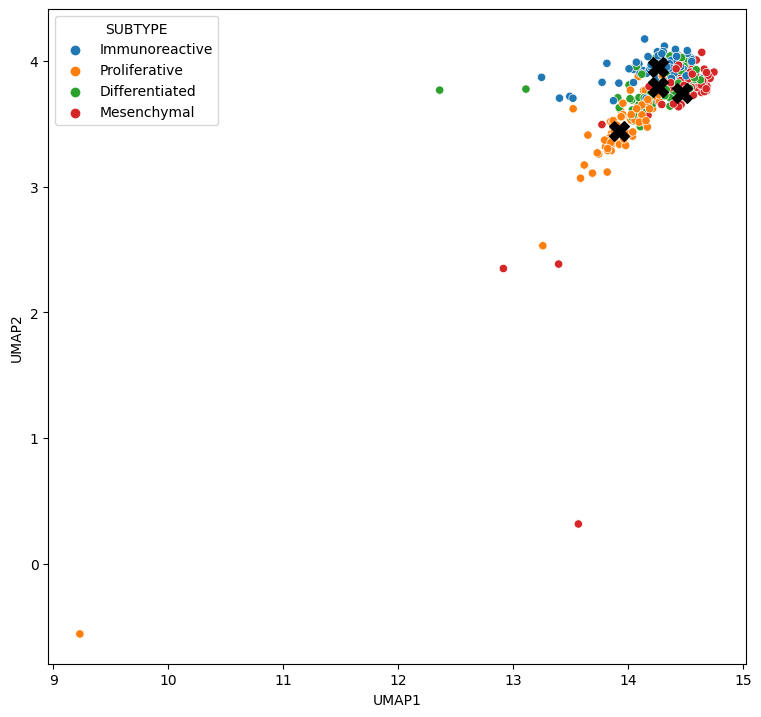

<Figure size 640x480 with 0 Axes>

In [62]:
plt.figure(figsize=(9, 8.5))
sns.scatterplot(data=merged_latent_ov_df_0p90, x="UMAP1", y="UMAP2", hue="SUBTYPE")
# plt.xlim(4, 5.5)
# plt.ylim(10, 11.5)
# Calculate the mean for each category
means = merged_latent_ov_df_0p90.groupby("SUBTYPE").mean()

# Add mean points to the plot
for index, row in means.iterrows():
    plt.scatter(row["UMAP1"], row["UMAP2"], marker="X", color="black", s=200)

# Show the plot
plt.show()
plt.savefig("../../Desktop/Subtype0p90.png")

In [63]:
set(merged_latent_ov_df["SUBTYPE"])

{'Differentiated', 'Immunoreactive', 'Mesenchymal', 'Proliferative'}

In [64]:
specific_values = ["Proliferative"]

In [65]:
merged_latent_ov_filtered_df = merged_latent_ov_df[
    merged_latent_ov_df["SUBTYPE"].isin(specific_values)
]
merged_latent_ov_filtered_df_0p90 = merged_latent_ov_df_0p90[
    merged_latent_ov_df_0p90["SUBTYPE"].isin(specific_values)
]

/var/folders/pz/58p838cs59d_ph9d15d3ltgc0000gs/T/ipykernel_51134/116838118.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means = merged_latent_ov_filtered_df.groupby("SUBTYPE").mean()
/var/folders/pz/58p838cs59d_ph9d15d3ltgc0000gs/T/ipykernel_51134/116838118.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  means_noise = merged_latent_ov_filtered_df_0p90.groupby("SUBTYPE").mean()


<Axes: title={'center': 'Proliferative'}, xlabel='UMAP1', ylabel='UMAP2'>

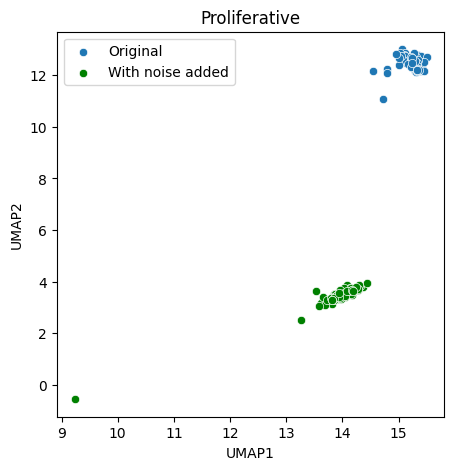

In [66]:
plt.figure(figsize=(5, 5))
plt.title(specific_values[0])
sns.scatterplot(
    data=merged_latent_ov_filtered_df, x="UMAP1", y="UMAP2", label="Original"
)

means = merged_latent_ov_filtered_df.groupby("SUBTYPE").mean()


means_noise = merged_latent_ov_filtered_df_0p90.groupby("SUBTYPE").mean()

sns.scatterplot(
    data=merged_latent_ov_filtered_df_0p90,
    x="UMAP1",
    y="UMAP2",
    color="green",
    label="With noise added",
)
# Add mean points to the plot

# plt.xlim(4, 5.5)
# plt.ylim(10, 11.5)
# Calculate the mean for each category

In [67]:
noisy_datasets.keys()

dict_keys(['tcga_rnaseq_df_0p1', 'tcga_rnaseq_df_0p18', 'tcga_rnaseq_df_0p36', 'tcga_rnaseq_df_0p54', 'tcga_rnaseq_df_0p72', 'tcga_rnaseq_df_0p90'])

In [68]:
import random

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.neighbors import KNeighborsClassifier

random.seed(42)

Noise = []
AUC_ROC = []
F1_score = []
Accuracy = []
for key in noisy_datasets.keys():
    Noise.append(float(key.split("_")[-1].replace("p", ".")))
    latent_mu, latent_sigma = VAE_latent_out(noisy_datasets[key])
    # Extract the features from the DataFrame
    features = latent_mu.iloc[:, 0:-1].values

    # Perform UMAP dimensionality reduction
    umap_result = umap.UMAP().fit_transform(features)

    # Create a new DataFrame with UMAP coordinates
    umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])

    # Concatenate the UMAP DataFrame with the original DataFrame
    result_df = pd.concat([latent_mu, umap_df], axis=1)

    embedded_dataframe = result_df.copy()
    embedded_dataframe["id"] = df["Unnamed: 0"]

    merged_latent_clinical_df = pd.merge(
        clincal_df, embedded_dataframe, on="id", how="inner"
    )

    # Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

    # Split the DataFrame into features (X) and labels (y)
    merged_l_df = merged_latent_clinical_df.copy()
    merged_l_df = merged_l_df.dropna()

    merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes

    X = merged_l_df[["UMAP1", "UMAP2"]]
    y = merged_l_df["acronym"]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Initialize and train the classifier
    ## Make an LDA object
    LDA = LinearDiscriminantAnalysis()

    ## Make a QDA object
    QDA = QuadraticDiscriminantAnalysis()
    classifier = QDA
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Compute roc_auc_score
    auc_roc = roc_auc_score(
        pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro"
    )

    # Compute F1-score
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0.0)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Compute classification report
    classification_metrics = classification_report(y_test, y_pred, zero_division=0.0)

    AUC_ROC.append(auc_roc)
    F1_score.append(f1)
    Accuracy.append(accuracy)
    # Print the AUC-ROC, F1-score, accuracy, and classification report
    # print(key)
    # print("AUC-ROC:", auc_roc)
    # print("F1-score:", f1)
    # print("Accuracy:", accuracy)
    # print("********************************")
    # print("Classification Report:\n", classification_metrics)

Text(0.5, 0, 'Gaussian Noise Amplitude')

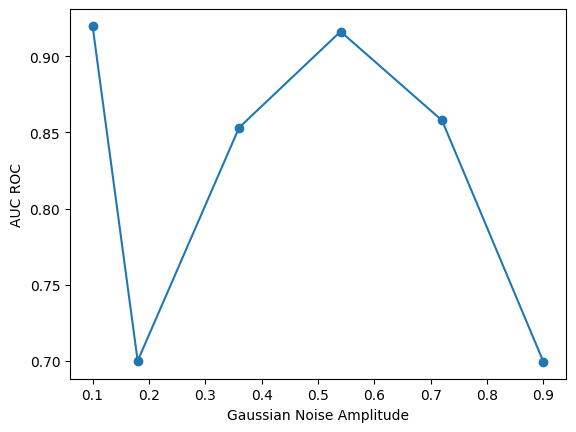

In [69]:
plt.plot(Noise, AUC_ROC, "-o")
plt.ylabel("AUC ROC")
plt.xlabel("Gaussian Noise Amplitude")

Text(0.5, 0, 'Gaussian Noise Amplitude')

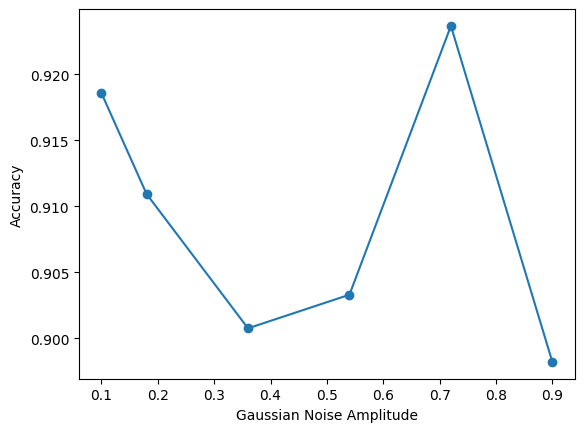

In [70]:
plt.plot(Noise, Accuracy, "-o")
plt.ylabel("Accuracy")
plt.xlabel("Gaussian Noise Amplitude")

Text(0.5, 0, 'Gaussian Noise Amplitude')

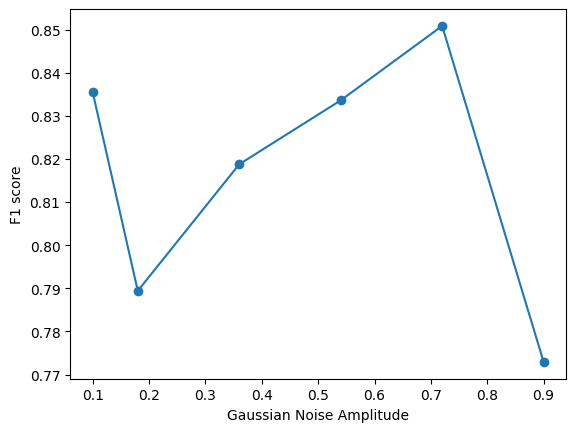

In [71]:
plt.plot(Noise, F1_score, "-o")
plt.ylabel("F1 score")
plt.xlabel("Gaussian Noise Amplitude")

In [72]:
rnaseq_df_masked = rnaseq_df.copy()

In [73]:
import json

# Open the file
with open("Mutinfo.json", "r") as f:
    # Load the JSON data from the file
    Mutinfo_genes = json.load(f)

In [89]:
len(Mutinfo_genes.keys())

100

In [75]:
tcga_tybalt_file_location = (
    "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
)
rnaseq_df = pd.read_table(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [77]:
import random

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.neighbors import KNeighborsClassifier

random.seed(42)

Noise = []

AUC_ROC = []
F1_score = []
Accuracy = []

AUC_ROC_masked = []
F1_score_masked = []
Accuracy_masked = []

for key in noisy_datasets.keys():
    Noise.append(float(key.split("_")[-1].replace("p", ".")))
    dataset = noisy_datasets[key]
    dataset_masked = dataset.copy()
    dataset_masked[list(Mutinfo_genes.keys())] = 0

    latent_mu, latent_sigma = VAE_latent_out(dataset)
    latent_mu_masked, latent_sigma_masked = VAE_latent_out(dataset_masked)
    # Extract the features from the DataFrame
    features = latent_mu.iloc[:, 0:-1].values
    features_masked = latent_mu_masked.iloc[:, 0:-1].values

    # Perform UMAP dimensionality reduction
    umap_result = umap.UMAP().fit_transform(features)
    umap_result_masked = umap.UMAP().fit_transform(features_masked)
    
    # Create a new DataFrame with UMAP coordinates
    umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
    umap_df_masked = pd.DataFrame(umap_result_masked, columns=["UMAP1", "UMAP2"])

    # Concatenate the UMAP DataFrame with the original DataFrame
    result_df = pd.concat([latent_mu, umap_df], axis=1)
    result_df_masked = pd.concat([latent_mu_masked, umap_df_masked], axis=1)

    embedded_dataframe = result_df.copy()
    embedded_dataframe["id"] = df["Unnamed: 0"]
    
    embedded_dataframe_masked = result_df_masked.copy()
    embedded_dataframe_masked["id"] = df["Unnamed: 0"]

    merged_latent_clinical_df = pd.merge(
        clincal_df, embedded_dataframe, on="id", how="inner"
    )
    
    merged_latent_clinical_df_masked = pd.merge(
        clincal_df, embedded_dataframe_masked, on="id", how="inner"
    )

    # Assuming you have a pandas DataFrame named 'df' with features in 'features_column' and labels in 'label_column'

    # Split the DataFrame into features (X) and labels (y)
    merged_l_df = merged_latent_clinical_df.copy()
    merged_l_df = merged_l_df.dropna()
    
    merged_l_df_masked = merged_latent_clinical_df_masked.copy()
    merged_l_df_masked = merged_l_df_masked.dropna()

    merged_l_df["acronym"] = merged_l_df["acronym"].astype("category").cat.codes
    merged_l_df_masked["acronym"] = merged_l_df_masked["acronym"].astype("category").cat.codes
    
    
    X = merged_l_df[["UMAP1", "UMAP2"]]
    y = merged_l_df["acronym"]
    
    X_masked = merged_l_df_masked[["UMAP1", "UMAP2"]]
    y_masked = merged_l_df_masked["acronym"]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Split the data into train and test sets
    X_train_masked, X_test_masked, y_train_masked, y_test_masked = train_test_split(
        X_masked, y_masked, test_size=0.2, random_state=42, stratify=y_masked
    )

    
    # Initialize and train the classifier
    ## Make an LDA object
    LDA = LinearDiscriminantAnalysis()

    ## Make a QDA object
    QDA = QuadraticDiscriminantAnalysis()
    classifier = QDA
    classifier.fit(X_train, y_train)

    ## Make a QDA object
    QDA_masked = QuadraticDiscriminantAnalysis()
    classifier_masked = QDA_masked
    classifier_masked.fit(X_train_masked, y_train_masked)
    
    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Make predictions on the test set
    y_pred_masked = classifier_masked.predict(X_test_masked)
    
    # Compute roc_auc_score
    auc_roc = roc_auc_score(
        pd.get_dummies(y_test), pd.get_dummies(y_pred), average="macro"
    )
    
    auc_roc_masked = roc_auc_score(
        pd.get_dummies(y_test_masked), pd.get_dummies(y_pred_masked), average="macro"
    )


    # Compute F1-score
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0.0)
    f1_masked = f1_score(y_test_masked, y_pred_masked, average="macro", zero_division=0.0)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_masked = accuracy_score(y_test_masked, y_pred_masked)

    # Compute classification report
    classification_metrics = classification_report(y_test, y_pred, zero_division=0.0)
    classification_metrics_masked = classification_report(y_test_masked, y_pred_masked, zero_division=0.0)

    AUC_ROC.append(auc_roc)
    F1_score.append(f1)
    Accuracy.append(accuracy)
    
    AUC_ROC_masked.append(auc_roc_masked)
    F1_score_masked.append(f1_masked)
    Accuracy_masked.append(accuracy_masked)
    # Print the AUC-ROC, F1-score, accuracy, and classification report
    # print(key)
    # print("AUC-ROC:", auc_roc)
    # print("F1-score:", f1)
    # print("Accuracy:", accuracy)
    # print("********************************")
    # print("Classification Report:\n", classification_metrics)

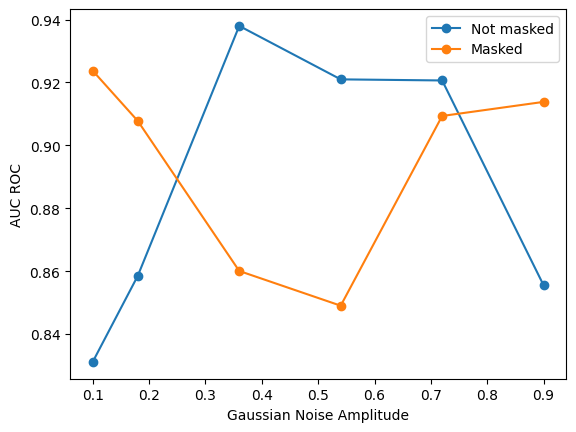

In [83]:
plt.plot(Noise, AUC_ROC, "-o", label = "Not masked")
plt.plot(Noise, AUC_ROC_masked, "-o", label = 'Masked')
plt.ylabel("AUC ROC")
plt.xlabel("Gaussian Noise Amplitude")
plt.legend()

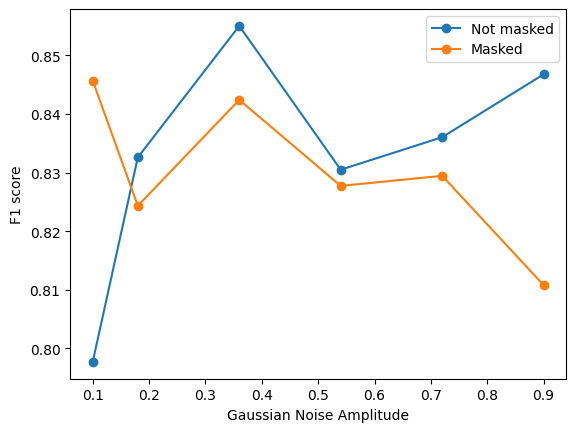

In [84]:
plt.plot(Noise, F1_score, "-o", label = "Not masked")
plt.plot(Noise, F1_score_masked, "-o", label = "Masked")
plt.ylabel("F1 score")
plt.xlabel("Gaussian Noise Amplitude")
plt.legend()

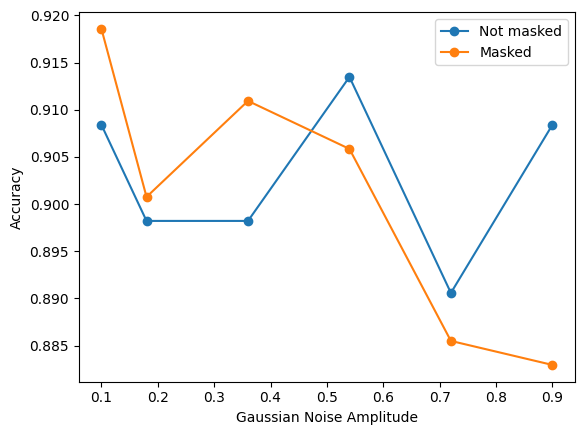

In [86]:
plt.plot(Noise, Accuracy, "-o", label = "Not masked")
plt.plot(Noise, Accuracy_masked, "-o", label = "Masked")
plt.ylabel("Accuracy")
plt.xlabel("Gaussian Noise Amplitude")
plt.legend()